## Imports and setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(font="sans-serif", style="white")
my_colors = ["#008080","#F08080","#FFD23F","#6B8E23","#BA55D3","#4682B4","#DAA520"]
sns.set_theme(context='notebook', style='white', palette=my_colors, font='serif', font_scale=1, color_codes=True, rc=None)

# Exploratory tests

## With clustering

In [72]:
df = pd.read_csv("results_experiments_aug.csv")

In [73]:
factors = ['target_prop', 'cluster', 'distance', 'anomaly_dist_method'] # factors to test

for factor in factors:
    print("Factor: ",factor, "\n")
    groups = [g['ba'].values for _, g in df.groupby(factor)]
    levels = df[factor].unique()
    
    print("Levels:",levels)
    
    if len(groups) == 2: # t-test if only 2 levels
        stat, p = stats.ttest_ind(*groups, equal_var=False)
        print("t-test: t =", round(stat,3), "p =", round(p,4)) # if normal

        u_stat, p_u = stats.mannwhitneyu(*groups, alternative='two-sided')
        print("Mann-Whitney: U =", round(u_stat,3), "p =", round(p_u,4)) # if normality questionable
        
    elif len(groups) > 2: # anova if >2 levels
        stat, p = stats.f_oneway(*groups)
        print("One-way ANOVA: F =", round(stat,3), "p =", round(p,4)) # if normal
        
        h_stat, p_h = stats.kruskal(*groups)
        print("Kruskal-Wallis: H =", round(h_stat,3)," p =", round(p_h,4)) # if normality questionable


Factor:  target_prop 

Levels: [0.01 0.05 0.1  0.2 ]
One-way ANOVA: F = 3.927 p = 0.0085
Kruskal-Wallis: H = 3.526  p = 0.3175
Factor:  cluster 

Levels: ['cluster_pam_dafi_gower' 'cluster_pam_gower' 'cluster_kamila'
 'cluster_kproto']
One-way ANOVA: F = 2.484 p = 0.0595
Kruskal-Wallis: H = 7.101  p = 0.0687
Factor:  distance 

Levels: ['gower_matrix' 'dafi_gower_matrix']
t-test: t = -1.496 p = 0.1352
Mann-Whitney: U = 91337.0 p = 0.5903
Factor:  anomaly_dist_method 

Levels: ['SD' 'MAD' 'IQR']
One-way ANOVA: F = 0.264 p = 0.7678
Kruskal-Wallis: H = 2.224  p = 0.3289


### Thresholding method

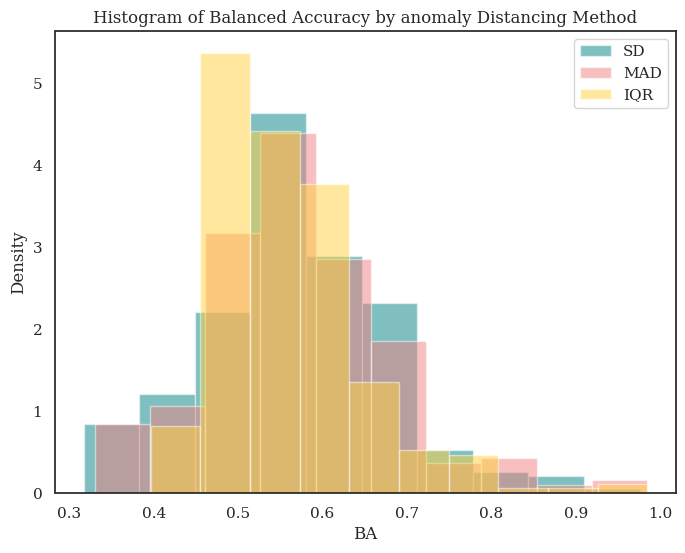

In [74]:
categories = df['anomaly_dist_method'].unique()

plt.figure(figsize=(8,6))
for cat in categories:
    sub = df[df['anomaly_dist_method'] == cat]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=cat, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by anomaly Distancing Method")
plt.legend();

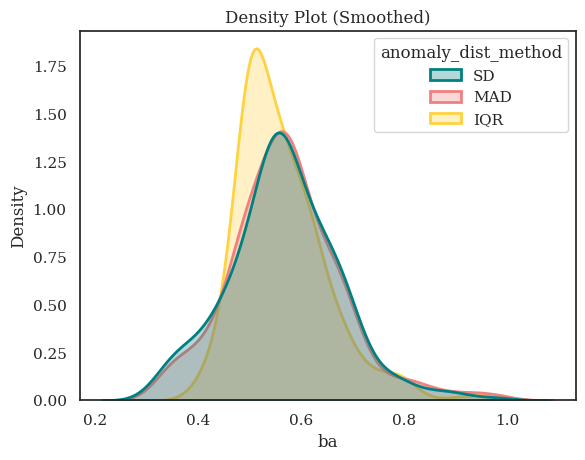

In [75]:
sns.kdeplot(data=df,x='ba',hue='anomaly_dist_method',fill=True, alpha = 0.3, lw = 2)
plt.title("Density Plot (Smoothed)");

### Target proportion

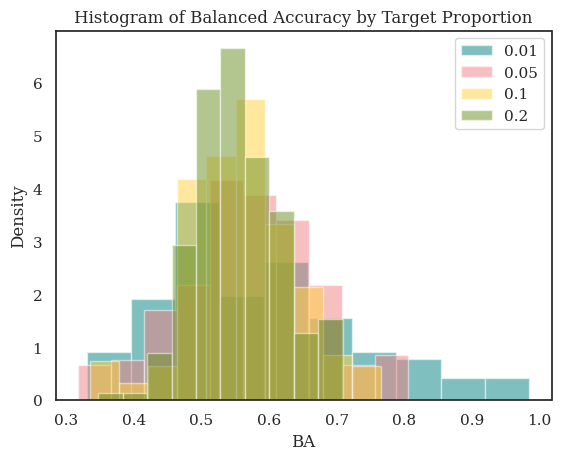

In [76]:
categories = [0.01, 0.05, 0.1, 0.2]

for cat in categories:
    sub = df[df['target_prop'] == cat]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=cat, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Target Proportion")
plt.legend();

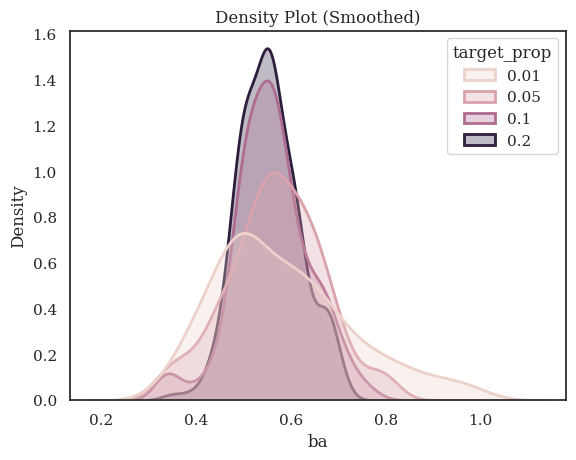

In [77]:
sns.kdeplot(data=df[df['target_prop'].isin(categories)], x='ba', hue='target_prop', fill=True, alpha = 0.3,lw = 2)
plt.title("Density Plot (Smoothed)");

### Clustering method

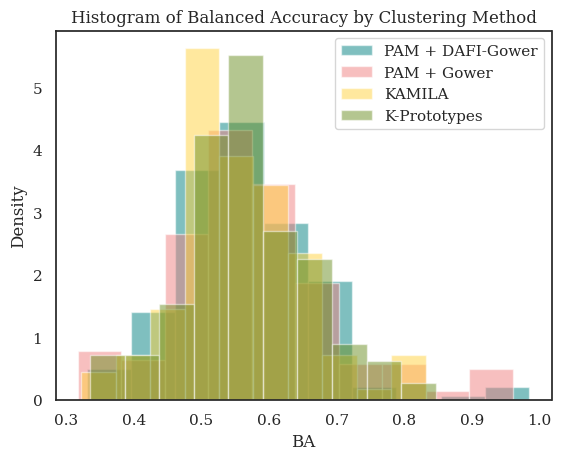

In [78]:
categories = ['cluster_pam_dafi_gower', 'cluster_pam_gower', 'cluster_kamila','cluster_kproto']
clustering_names = ['PAM + DAFI-Gower','PAM + Gower', 'KAMILA', 'K-Prototypes']
clust_names_dict = dict(zip(categories,clustering_names))

for cat in categories:
    sub = df[df['cluster'] == cat]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=clust_names_dict[cat], density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Clustering Method")
plt.legend();

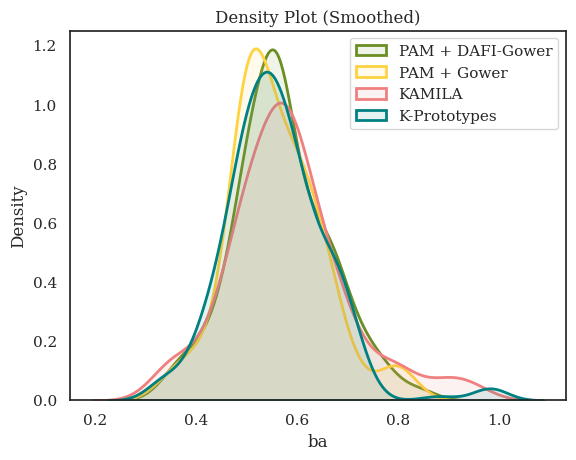

In [79]:
sns.kdeplot(data=df,x='ba',hue='cluster',fill=True,alpha = 0.1,lw = 2)
plt.legend(clustering_names)
plt.title("Density Plot (Smoothed)");

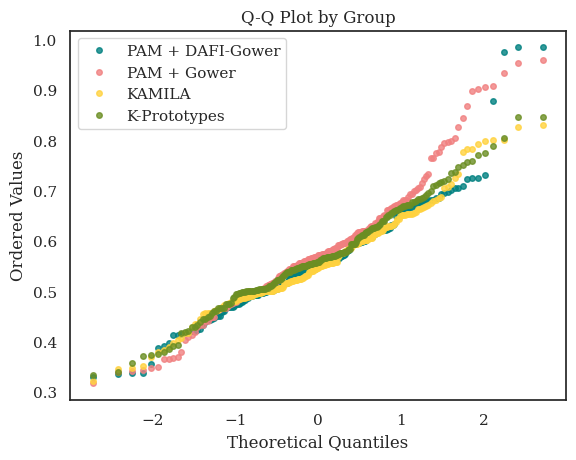

In [80]:
for c in categories:
    data = df[df['cluster'] == c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=clust_names_dict[c])

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

### Distance metric

In [81]:
categories = df['distance'].unique()
dist_names_dict = {'gower_matrix':'Gower distance','dafi_gower_matrix':'DAFI-Gower distance'}

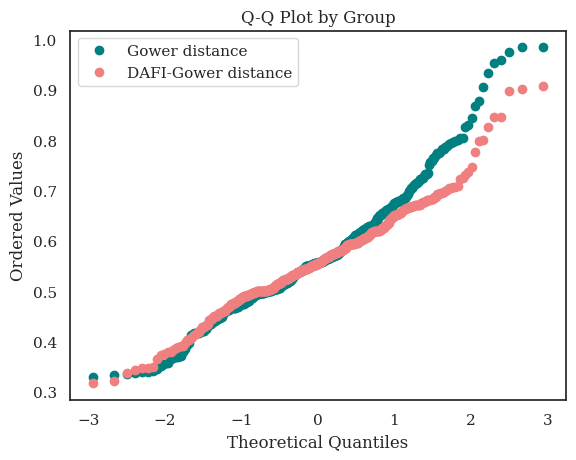

In [82]:
for c in categories:
    data = df[df['distance'] == c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', label=dist_names_dict[c])

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend()

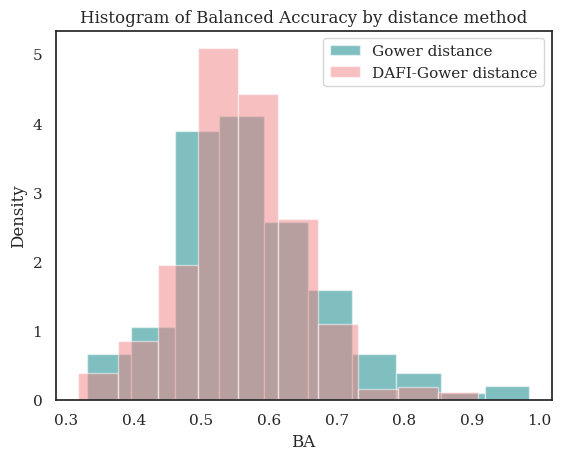

In [83]:
for cat in categories:
    sub = df[df['distance'] == cat]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=dist_names_dict[cat], density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by distance method")
plt.legend();


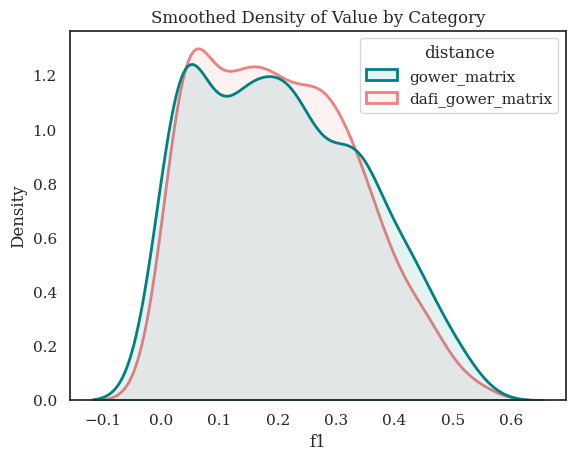

In [84]:
sns.kdeplot(data=df,x='f1',hue='distance',fill=True,alpha = 0.1,lw = 2)
plt.title("Smoothed Density of Value by Category");

# Plots and tests for results analysis

In [85]:
df = pd.read_csv("results_experiments_aug.csv")

In [86]:
df['Sensitivity'] = df['TP']/(df['TP']+df['FN'])

## Target proportion

### Plots

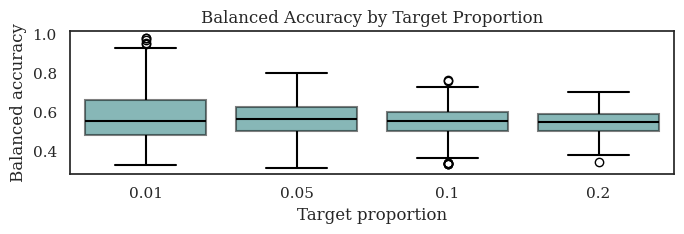

In [119]:
plt.figure(figsize=(7, 2.5))
sns.boxplot(x='target_prop', y='ba', data=df, linecolor="black", linewidth=1.5, boxprops=dict(alpha=.5))
plt.title("Balanced Accuracy by Target Proportion")
plt.xlabel("Target proportion")
plt.ylabel("Balanced accuracy")
plt.tight_layout();

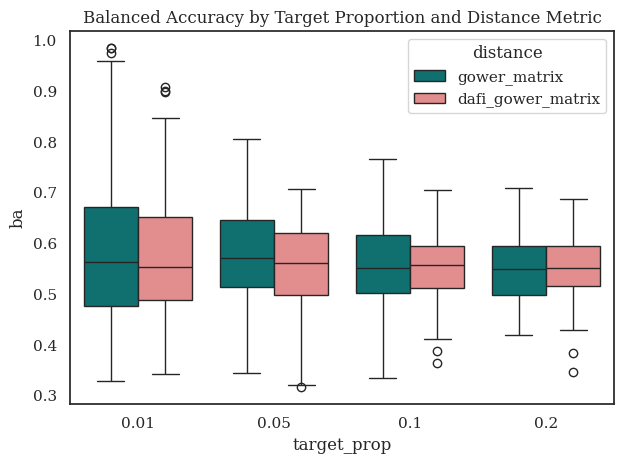

In [88]:
sns.boxplot(x='target_prop', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy by Target Proportion and Distance Metric")
plt.tight_layout();

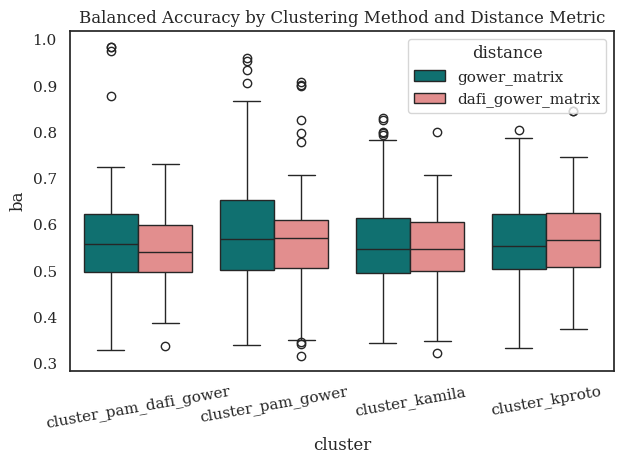

In [89]:
sns.boxplot(x='cluster', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy by Clustering Method and Distance Metric")
plt.xticks(rotation=10)
plt.tight_layout();

### Tests

#### ANOVA

In [90]:
groups = [g['ba'].values for _, g in df.groupby('target_prop')]
levels = df['target_prop'].unique()

if len(groups) == 2:
    # t-test
    stat, p = stats.ttest_ind(*groups, equal_var=False)
    print("t-test: t =", round(stat,3), "p =", round(p,4))
    
elif len(groups) > 2:
    # anova
    stat, p = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F =", round(stat,4), "p =", round(p,4))

One-way ANOVA: F = 3.9271 p = 0.0085


#### Normality checks

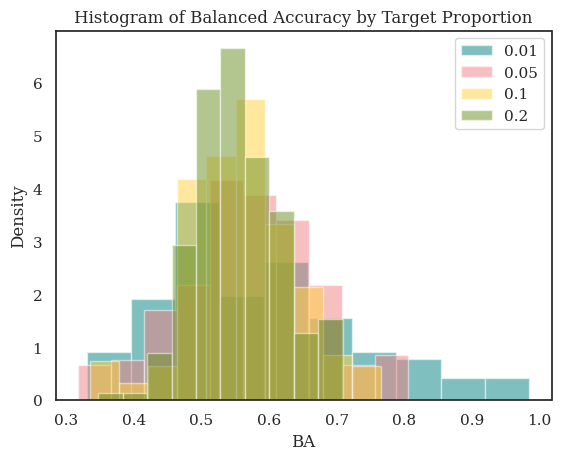

In [91]:
categories = [0.01, 0.05, 0.1, 0.2]

for cat in categories:
    sub = df[df['target_prop'] == cat]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=cat, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Target Proportion")
plt.legend();

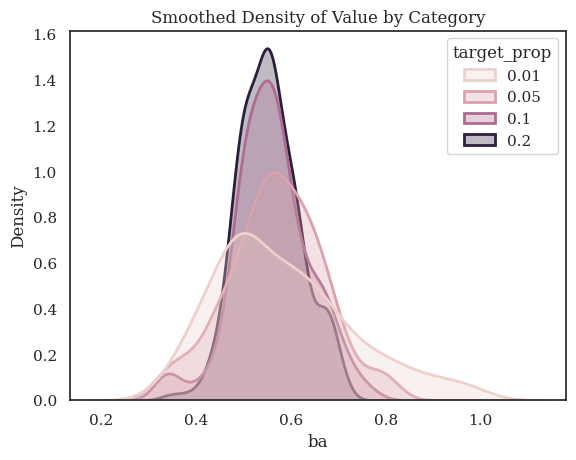

In [92]:
sns.kdeplot(data=df[df['target_prop'].isin(categories)],x='ba',hue='target_prop',fill=True,alpha = 0.3,lw = 2)
plt.title("Smoothed Density of Value by Category");

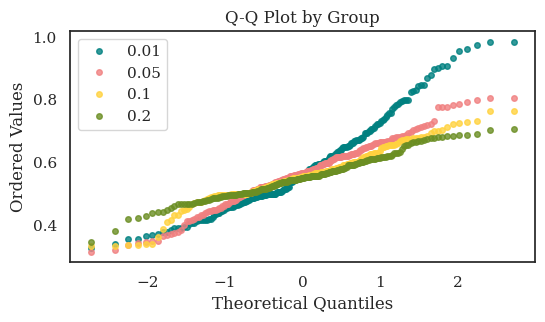

In [93]:
plt.figure(figsize=(6,3))
for c in categories:
    data = df[df['target_prop'] == c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=c)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

#### T-tests

In [94]:
target_pairs = [(0.01, 0.05), (0.05, 0.1), (0.1, 0.2), (0.01, 0.1), (0.01, 0.2), (0.05, 0.2)]
ttest_results = []

for b1, b2 in target_pairs:
    ba1 = df[df['target_prop'] == b1]['ba']
    ba2 = df[df['target_prop'] == b2]['ba']

    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,0.01,0.05,0.584977,0.567081,1.497379,0.135115
1,0.05,0.10,0.567081,0.558732,0.956526,0.339373
2,0.10,0.20,0.558732,0.553793,0.710376,0.477874
3,0.01,0.10,0.584977,0.558732,2.345274,0.019596
4,0.01,0.20,0.584977,0.553793,2.908288,0.003908
5,0.05,0.20,0.567081,0.553793,1.636470,0.102604


In [95]:
target_pairs = [(0.01, 0.05), (0.05, 0.1), (0.1, 0.2), (0.01, 0.1), (0.01, 0.2), (0.05, 0.2)]
ttest_results = []

for b1, b2 in target_pairs:
    ba1 = df[df['target_prop'] == b1]['Sensitivity']
    ba2 = df[df['target_prop'] == b2]['Sensitivity']

    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,0.01,0.05,0.368298,0.397532,-1.152205,0.249971
1,0.05,0.10,0.397532,0.369045,1.440308,0.150508
2,0.10,0.20,0.369045,0.347046,1.118557,0.263954
3,0.01,0.10,0.368298,0.369045,-0.029568,0.976427
4,0.01,0.20,0.368298,0.347046,0.840469,0.401185
5,0.05,0.20,0.397532,0.347046,2.550241,0.011111


## Thresholding methods

### Plots

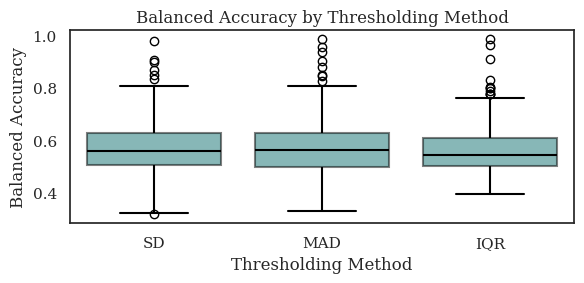

In [96]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='anomaly_dist_method', y='ba', data=df, linecolor="black", linewidth=1.5, boxprops=dict(alpha=.5))
plt.title("Balanced Accuracy by Thresholding Method")
plt.xlabel("Thresholding Method")
plt.ylabel("Balanced Accuracy")
plt.tight_layout();

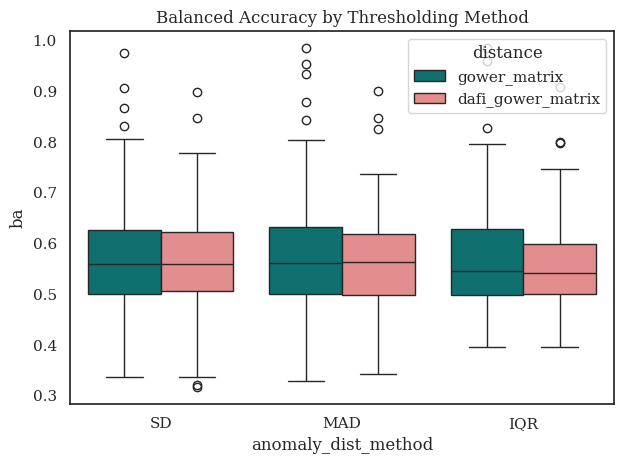

In [97]:
sns.boxplot(x='anomaly_dist_method', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy by Thresholding Method")
plt.tight_layout()

### Tests

#### ANOVA

In [98]:
groups = [g['ba'].values for _, g in df.groupby('anomaly_dist_method')]
levels = df['anomaly_dist_method'].unique()

if len(groups) == 2:
    # t-test
    stat, p = stats.ttest_ind(*groups, equal_var=False)
    print("t-test: t =", round(stat,3), "p =", round(p,4))
    
elif len(groups) > 2:
    # anova
    stat, p = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F =", round(stat,4), "p =", round(p,4))

One-way ANOVA: F = 0.2643 p = 0.7678


#### Normality checks

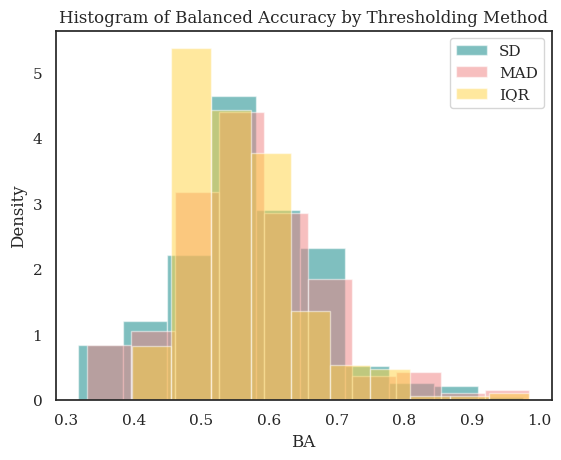

In [99]:
for met in df['anomaly_dist_method'].unique():
    sub = df[df['anomaly_dist_method'] == met]
    plt.hist(sub['ba'], bins=10, alpha=0.5, label=met, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Thresholding Method")
plt.legend();

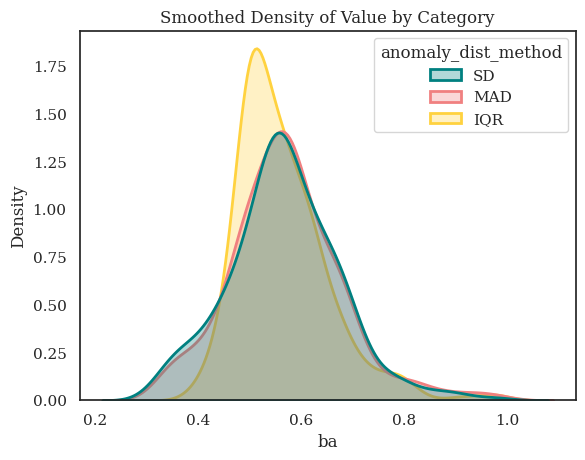

In [100]:
sns.kdeplot(data=df,x='ba',hue='anomaly_dist_method',fill=True,alpha = 0.3,lw = 2)
plt.title("Smoothed Density of Value by Category");

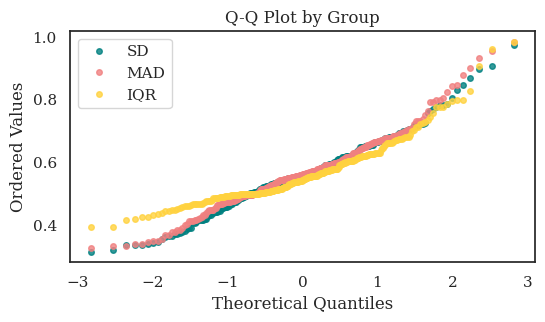

In [101]:
plt.figure(figsize=(6,3))

for c in df['anomaly_dist_method'].unique():
    data = df[df['anomaly_dist_method']==c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=c)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

#### T-tests

In [102]:
# t-tests ba
thrsh_pairs = [('SD', 'MAD'), ('SD', 'IQR'),('MAD', 'IQR')]
ttest_results = []

for b1, b2 in thrsh_pairs:
    ba1 = df[df['anomaly_dist_method'] == b1]['ba']
    ba2 = df[df['anomaly_dist_method'] == b2]['ba']
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,SD,MAD,0.566034,0.569297,-0.361691,0.717716
1,SD,IQR,0.566034,0.563107,0.355616,0.722264
2,MAD,IQR,0.569297,0.563107,0.747791,0.454904


In [103]:
# t-tests sensitivity
ttest_results = []

for b1, b2 in thrsh_pairs:
    ba1 = df[df['anomaly_dist_method'] == b1]['Sensitivity']
    ba2 = df[df['anomaly_dist_method'] == b2]['Sensitivity']
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,SD,MAD,0.441396,0.418409,1.190207,2.344680e-01
1,SD,IQR,0.441396,0.251636,11.075581,5.895004e-26
2,MAD,IQR,0.418409,0.251636,8.930881,6.456731e-18


## Distance: Gower vs. DAFI

### Plots

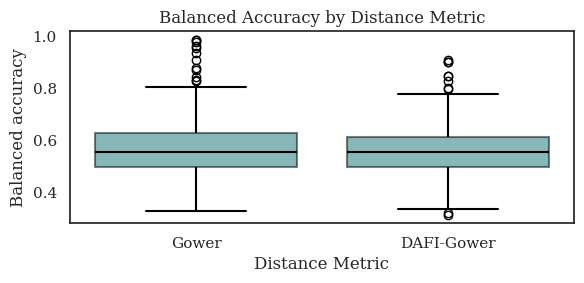

In [104]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='distance', y='ba', data=df, linecolor="black", linewidth=1.5, boxprops=dict(alpha=.5))
plt.title("Balanced Accuracy by Distance Metric")
plt.xlabel("Distance Metric")
plt.ylabel("Balanced accuracy")
plt.tight_layout()
plt.xticks([0,1],["Gower", "DAFI-Gower"]);

### Tests

#### ANOVA

In [105]:
groups = [g['ba'].values for _, g in df.groupby('distance')]
levels = df['distance'].unique()

if len(groups) == 2:
    # t-test
    stat, p = stats.ttest_ind(*groups, equal_var=False)
    print("t-test: t =", round(stat,3), "p =", round(p,4))
    
elif len(groups) > 2:
    # anova
    stat, p = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F =", round(stat,4), "p =", round(p,4))

t-test: t = -1.496 p = 0.1352


#### Normality checks

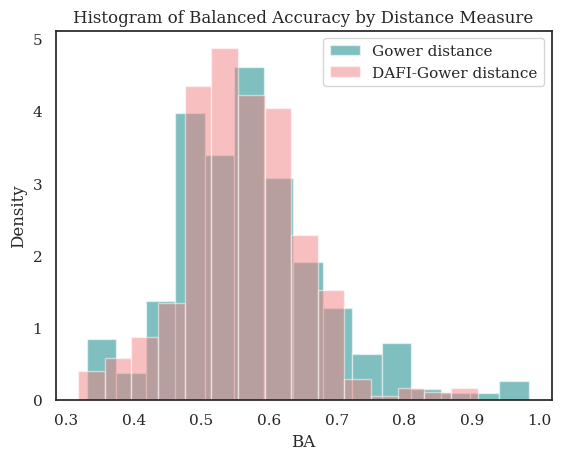

In [106]:
for met in df['distance'].unique():
    sub = df[(df['distance'] == met)]
    plt.hist(sub['ba'], bins=15, alpha=0.5, label=dist_names_dict[met], density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Distance Measure")
plt.legend();

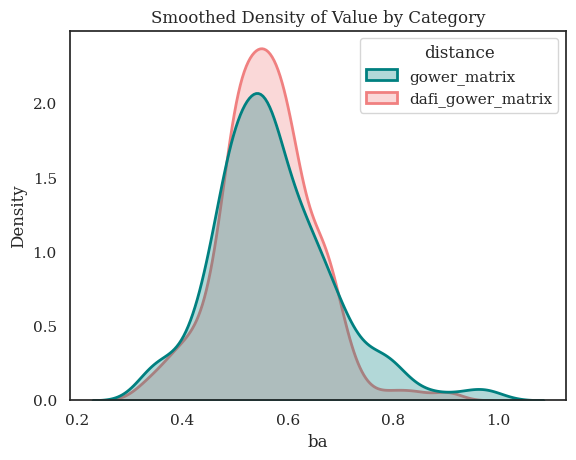

In [107]:
sns.kdeplot(data=df,x='ba',hue='distance',fill=True,alpha = 0.3,lw = 2)
plt.title("Smoothed Density of Value by Category");

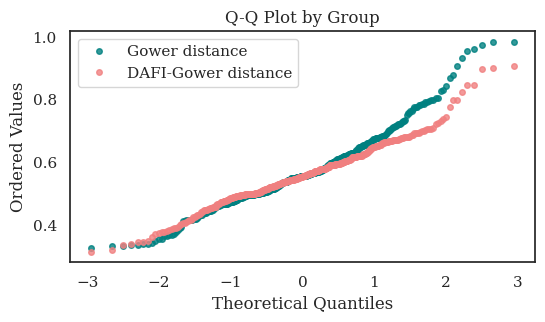

In [108]:
plt.figure(figsize=(6,3))

for c in df['distance'].unique():
    data = df[df['distance']==c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=dist_names_dict[c])

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

#### T-tests

In [109]:
ttest_results = []

ba1 = df[df['distance'] == "gower_matrix"]['ba']
ba2 = df[df['distance'] == "dafi_gower_matrix"]['ba']
    
t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False)
ttest_results.append({
    'group1': "Gower",
    'group2': "DAFI-Gower",
    'mean1': ba1.mean(),
    'mean2': ba2.mean(),
    't_stat': t_stat,
    'p_val': p_val
})

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,Gower,DAFI-Gower,0.571338,0.560954,1.495523,0.135162


In [110]:
ttest_results = []

ba1 = df[df['distance'] == "gower_matrix"]['Sensitivity']
ba2 = df[df['distance'] == "dafi_gower_matrix"]['Sensitivity']
    
t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False)
ttest_results.append({
    'group1': "gower_matrix",
    'group2': "dafi_gower_matrix",
    'mean1': ba1.mean(),
    'mean2': ba2.mean(),
    't_stat': t_stat,
    'p_val': p_val
})

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,gower_matrix,dafi_gower_matrix,0.380157,0.360804,1.204646,0.228671


## lambda plots

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lh/s2l49w850tq2lvbfyqst82j00000gn/T/ipykernel_22290/910084931.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Distribution of Best $\lambda$ Values by Thresholding Method")
/var/folders/lh/s2l49w850tq2lvbfyqst82j00000gn/T/ipykernel_22290/910084931.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Best $\lambda$")


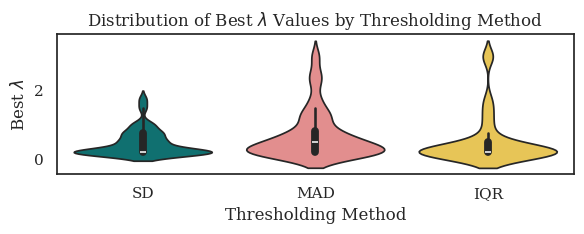

In [114]:
plt.figure(figsize=(6, 2.5))
sns.violinplot(x='anomaly_dist_method', y='best_lambda', hue='anomaly_dist_method', data=df)
plt.title("Distribution of Best $\lambda$ Values by Thresholding Method")
plt.ylabel("Best $\lambda$")
plt.xlabel("Thresholding Method")
plt.tight_layout();

# Plots and tests - single cluster case

In [42]:
df = pd.read_csv("results_experiments_single_aug.csv")

In [43]:
df['Sensitivity'] = df['TP']/(df['TP']+df['FN'])

## Target proportion

### Plots

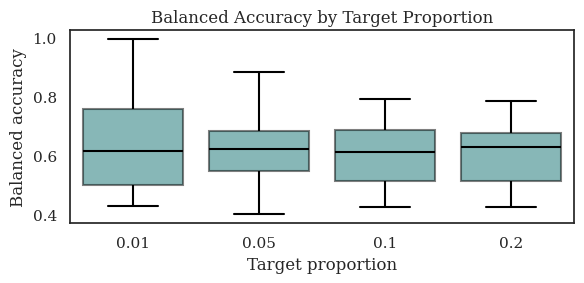

In [44]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='target_prop', y='ba', data=df, linecolor="black", linewidth=1.5, boxprops=dict(alpha=.5))
plt.title("Balanced Accuracy by Target Proportion")
plt.xlabel("Target proportion")
plt.ylabel("Balanced accuracy")
plt.tight_layout();

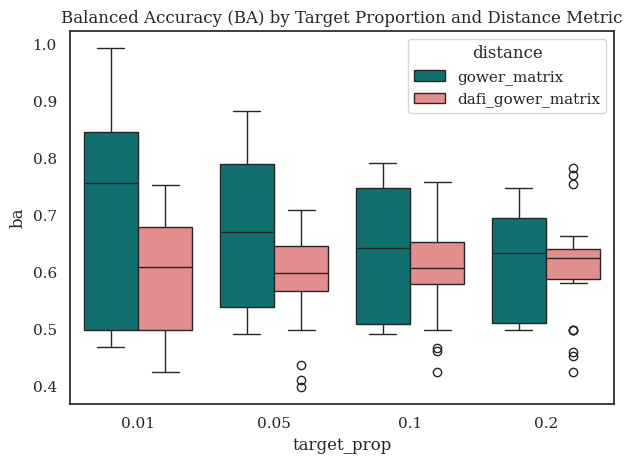

In [45]:
sns.boxplot(x='target_prop', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy (BA) by Target Proportion and Distance Metric")
plt.tight_layout();

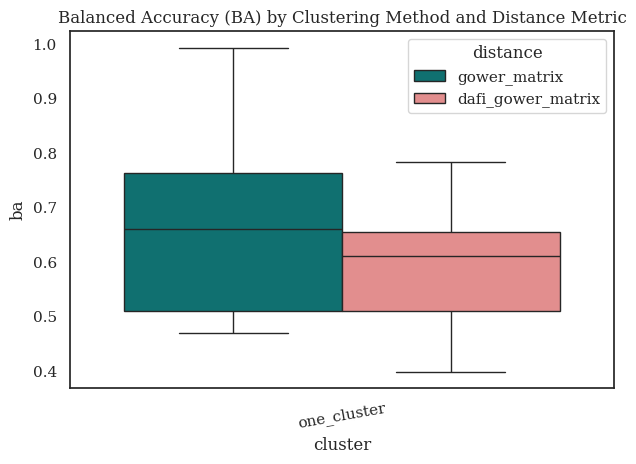

In [46]:
sns.boxplot(x='cluster', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy (BA) by Clustering Method and Distance Metric")
plt.xticks(rotation=10)
plt.tight_layout();

### Tests

#### ANOVA

In [47]:
groups = [g['ba'].values for _, g in df.groupby('target_prop')]
levels = df['target_prop'].unique()

if len(groups) == 2:
    # t-test
    stat, p = stats.ttest_ind(*groups, equal_var=False)
    print("t-test: t =", round(stat,3), "p =", round(p,4))
    
elif len(groups) > 2:
    # anova
    stat, p = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F =", round(stat,4), "p =", round(p,4))

One-way ANOVA: F = 0.8908 p = 0.4467


#### Normality checks

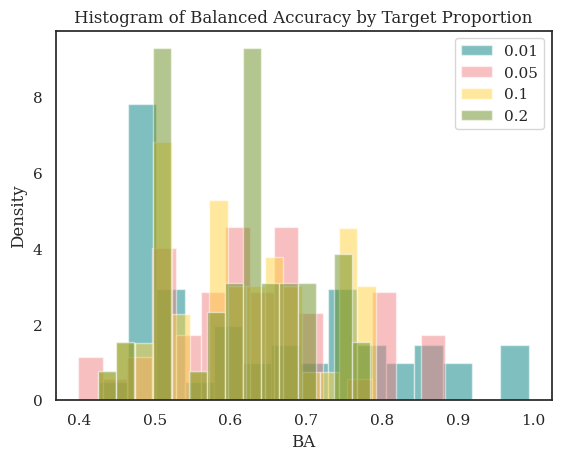

In [48]:
categories = [0.01, 0.05, 0.1, 0.2]

for cat in categories:
    sub = df[df['target_prop'] == cat]
    plt.hist(sub['ba'], bins=15, alpha=0.5, label=cat, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Target Proportion")
plt.legend();

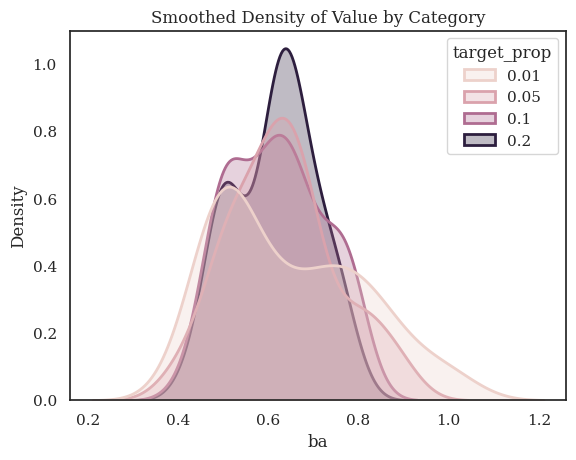

In [49]:
sns.kdeplot(data=df[df['target_prop'].isin(categories)],x='ba',hue='target_prop',fill=True,alpha = 0.3,lw = 2)
plt.title("Smoothed Density of Value by Category");

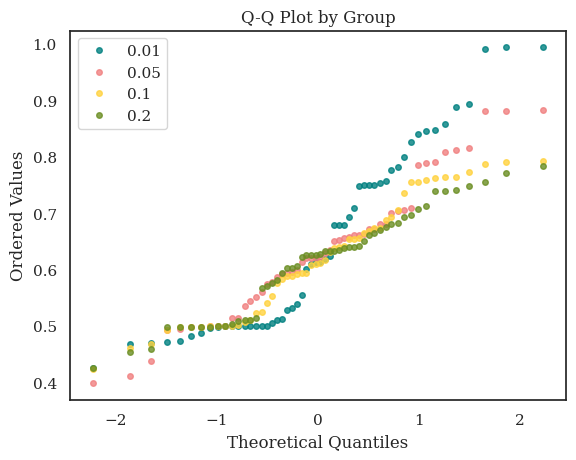

In [50]:
for c in categories:
    data = df[df['target_prop'] == c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=c)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

#### T-tests

In [51]:
target_pairs = [(0.01, 0.05), (0.05, 0.1), (0.1, 0.2), (0.01, 0.1), (0.01, 0.2), (0.05, 0.2)]
ttest_results = []

for b1, b2 in target_pairs:
    ba1 = df[df['target_prop'] == b1]['ba']
    ba2 = df[df['target_prop'] == b2]['ba']
    
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,0.01,0.05,0.646982,0.630029,0.627545,0.531773
1,0.05,0.10,0.630029,0.616672,0.630896,0.529492
2,0.10,0.20,0.616672,0.612713,0.212897,0.831822
3,0.01,0.10,0.646982,0.616672,1.172972,0.243902
4,0.01,0.20,0.646982,0.612713,1.368243,0.174889
5,0.05,0.20,0.630029,0.612713,0.857464,0.393245


In [52]:
target_pairs = [(0.01, 0.05), (0.05, 0.1), (0.1, 0.2), (0.01, 0.1), (0.01, 0.2), (0.05, 0.2)]
ttest_results = []

for b1, b2 in target_pairs:
    ba1 = df[df['target_prop'] == b1]['Sensitivity']
    ba2 = df[df['target_prop'] == b2]['Sensitivity']
    
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False)
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,0.01,0.05,0.393651,0.418839,-0.411947,0.681275
1,0.05,0.10,0.418839,0.425258,-0.125365,0.900472
2,0.10,0.20,0.425258,0.425029,0.004694,0.996263
3,0.01,0.10,0.393651,0.425258,-0.522300,0.602653
4,0.01,0.20,0.393651,0.425029,-0.529899,0.597436
5,0.05,0.20,0.418839,0.425029,-0.124642,0.901045


## Thresholding methods

### Plots

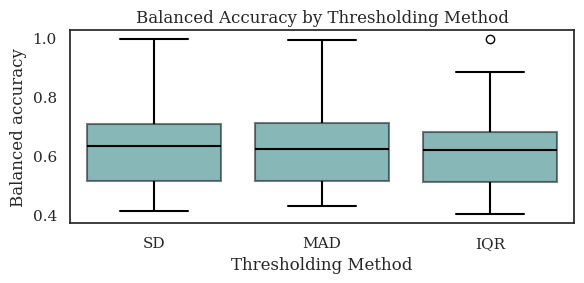

In [53]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='anomaly_dist_method', y='ba', data=df, linecolor="black", linewidth=1.5, boxprops=dict(alpha=0.5))
plt.title("Balanced Accuracy by Thresholding Method")
plt.xlabel("Thresholding Method")
plt.ylabel("Balanced accuracy")
plt.tight_layout();

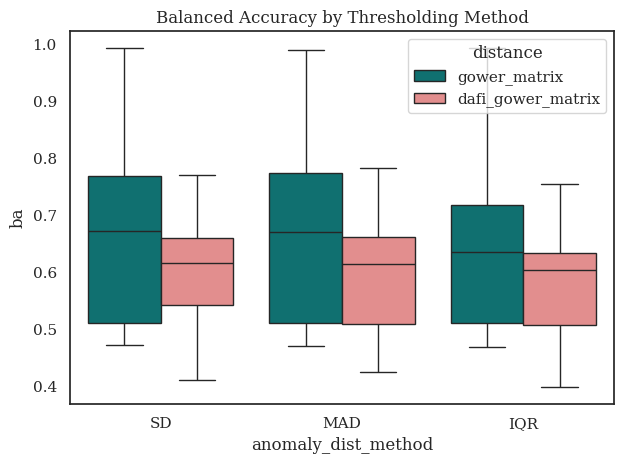

In [54]:
sns.boxplot(x='anomaly_dist_method', y='ba', hue='distance', data=df)
plt.title("Balanced Accuracy by Thresholding Method")
plt.tight_layout()

### Tests

#### ANOVA

In [55]:
groups = [g['ba'].values for _, g in df.groupby('anomaly_dist_method')]
levels = df['anomaly_dist_method'].unique()

if len(groups) == 2:
    # t-test
    stat, p = stats.ttest_ind(*groups, equal_var=False)
    print("t-test: t =", round(stat,3), "p =", round(p,4))
    
elif len(groups) > 2:
    # anova
    stat, p = stats.f_oneway(*groups)
    print(f"One-way ANOVA: F =", round(stat,4), "p =", round(p,4))

One-way ANOVA: F = 0.4013 p = 0.6699


#### Normality checks

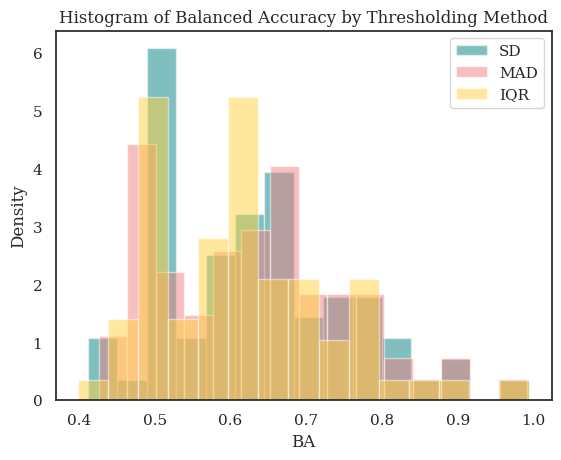

In [56]:
for met in df['anomaly_dist_method'].unique():
    subset = df[df['anomaly_dist_method'] == met]
    plt.hist(subset['ba'], bins=15, alpha=0.5, label=met, density=True)

plt.xlabel("BA") 
plt.ylabel("Density")
plt.title("Histogram of Balanced Accuracy by Thresholding Method")
plt.legend();


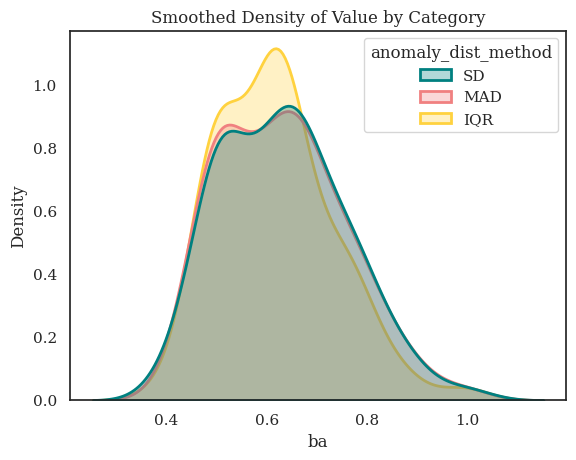

In [57]:
sns.kdeplot(data=df,x='ba',hue='anomaly_dist_method',fill=True,alpha = 0.3,lw = 2)
plt.title("Smoothed Density of Value by Category");

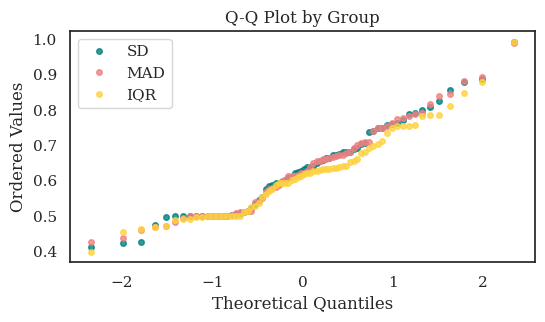

In [58]:
plt.figure(figsize=(6,3))

for c in df['anomaly_dist_method'].unique():
    data = df[df['anomaly_dist_method']==c]['ba']
    osm, osr = stats.probplot(data, dist="norm", fit=False)
    plt.plot(osm, osr, marker='o', linestyle='', alpha=0.8, markersize=4, label=c)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Data Quantiles")
plt.title("Q-Q Plot by Group")
plt.legend();

#### T-tests

In [59]:
# t-tests ba
thrsh_pairs = [('SD', 'MAD'), ('SD', 'IQR'),('MAD', 'IQR')]
ttest_results = []

for b1, b2 in thrsh_pairs:
    ba1 = df[df['anomaly_dist_method'] == b1]['ba']
    ba2 = df[df['anomaly_dist_method'] == b2]['ba']
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,SD,MAD,0.632331,0.631258,0.052008,0.958596
1,SD,IQR,0.632331,0.616208,0.811117,0.418665
2,MAD,IQR,0.631258,0.616208,0.758131,0.449637


In [60]:
# t-tests sensitivity
ttest_results = []

for b1, b2 in thrsh_pairs:
    ba1 = df[df['anomaly_dist_method'] == b1]['Sensitivity']
    ba2 = df[df['anomaly_dist_method'] == b2]['Sensitivity']
    t_stat, p_val = stats.ttest_ind(ba1, ba2, equal_var=False) # Welch's t-test
    ttest_results.append({
        'group1': b1,
        'group2': b2,
        'mean1': ba1.mean(),
        'mean2': ba2.mean(),
        't_stat': t_stat,
        'p_val': p_val
    })

pd.DataFrame(ttest_results)

,group1,group2,mean1,mean2,t_stat,p_val
0,SD,MAD,0.456889,0.451028,0.117166,0.906894
1,SD,IQR,0.456889,0.339165,2.598622,0.010392
2,MAD,IQR,0.451028,0.339165,2.456599,0.015290
